05/31
1. 保存实验结果，再load画图。这样方便之后修改图
2. 删去图上空白，添加noise_floor
3. 检查计算MSE时是否除以的是length长度
4. 使用直方图分析ML error

06/02
1. 自动在路径下建立存储ML_error的文件夹
2. 提前生成不同q下对应的trajectoies，生成truth和obs的函数分开写(完成且检查完毕)
3. 进行R_ml实验，采用自定义个数量（比如200）的个trajectories；修改保存文件的名称；修改bin的数量为20

06/04

1. Debug EKF code  
    a. HJacobian_at_v1,HJacobian_at_v2发现两个小错误:  
    delta_p_phi的分母的括号错了（所以才显示dimension问题，需要reshape）;  
    所有的x0,y0,z0指的都是q0的位置。这个坐标系以q0为中心，不需要initial target的位置信息.  
    b. 公式87的实现错误，已修正。（考虑其实也可以用导数相加的方法？）  
    c. 再看了下论文，发现就是忽略了modulo。为什么导数不考虑直接对公式求导？
2. 计划多生成几组数据 (进行中)  
    a.先尝试 50个25长度的trajectories，估计运行时间，同时检查EKFv1和v2区别
    b. phase_offset 改成0.3
    


 


In [1]:
import math
import numpy as np
import random
import matplotlib.pyplot as plt
import numpy.random as rd
from filterpy.kalman import ExtendedKalmanFilter
from filterpy.kalman import KalmanFilter
from filterpy.common import Q_discrete_white_noise
import pandas as pd
import seaborn as sns
import random
import os

np.random.seed(28)


from gene_tr import *
from ML_estimator import ML
from Evaluation import *
from KF import *
from Basic import *
from EKF import *

In [2]:
# ML parameters
f=8.6e8
lmb = 3e8/f
print(f'ML parameters: f:{f},lmb:{lmb}')
#array
N=10 # number of elements
d=0.25*lmb # distance between 2 adjacent elements
arr_dim=d*(N-1) # dimension of the array
arr=array(N,arr_dim,0) # array elements location

filepath = 'C:/Users/73160/OneDrive/项目/project/Weekly reports/Sp_16'
figsize = (12,9)

ML parameters: f:860000000.0,lmb:0.3488372093023256


# Generate data

In [3]:
def Exp1_generate_traj(N_tr,Length,dt,lmb,q):
    # trajectory parameters-1d
    F_1 = np.array([[1, dt], [0, 1]])
    H_1=np.array([1,0])  

    Q_1 =  (q**2)*np.array([[(dt**3)/3,(dt**2)/2],[(dt**2)/2,dt]]) 
    r = 0
    R_1 = r**2  # position observation noise

    # trajectory parameters-2d
    zero_2_2=np.zeros([2,2])
    zero_1_2=np.zeros([1,2])
    F = np.block([[F_1,zero_2_2],[zero_2_2,F_1]])
    H = np.block([[H_1,zero_1_2],[zero_1_2,H_1]])
    Q = np.block([[Q_1,zero_2_2],[zero_2_2,Q_1]])
    R = np.block([[R_1,0],[0,R_1]])

    # Generate N_tr trajectories and save them in a txt file
    real_states=np.zeros((N_tr,Length,4))

    for i in range (N_tr):
        #Initial speed
        v_x_start = np.random.uniform(3,5,1).squeeze()  #[3,5)  #x intial speed
        v_y_start = np.random.uniform(4,6,1).squeeze()  #[4,6)  #y initial speed
        X0 = np.array([0,v_x_start,1,v_y_start]).reshape(4,1)  #initial position not on (0,0) because there is an antenna
        r_s = GenerateTraj(Length,X0,F,Q) #genrate a trajectory from t=0 to t=(Length-1)*dt
        real_states[i,:,:] = r_s.reshape(Length,4)

    with open(f'trajectories_states_q_{q/lmb}lmb_l_{Length}_num_{N_tr}.txt', 'w') as outfile:
        for slice_2d in real_states:
            np.savetxt(outfile, slice_2d, fmt = '%f', delimiter = ',')


    real_states= np.loadtxt(f'trajectories_states_q_{q/lmb}lmb_l_{Length}_num_{N_tr}.txt', delimiter = ',').reshape((N_tr, Length, 4))


    return real_states


In [4]:
def Exp1_generate_obs(N_tr,Length,N_tr_used, Length_used, dt,position_noise_dB,lmb,N,arr,q,r_tr): 
    #Given N_tr*Length*4 real trajectories states with q, generate obsevations (positions, phases) under a specific noise level
    #r_tr: ratio allocated to training (computing R_ML)

    # trajectory parameters-1d
    F_1 = np.array([[1, dt], [0, 1]])
    H_1=np.array([1,0])  

    Q_1 =  (q**2)*np.array([[(dt**3)/3,(dt**2)/2],[(dt**2)/2,dt]]) 
    r = 0
    R_1 = r**2  # position observation noise

    # trajectory parameters-2d
    zero_2_2=np.zeros([2,2])
    zero_1_2=np.zeros([1,2])
    F = np.block([[F_1,zero_2_2],[zero_2_2,F_1]])
    H = np.block([[H_1,zero_1_2],[zero_1_2,H_1]])
    Q = np.block([[Q_1,zero_2_2],[zero_2_2,Q_1]])
    R = np.block([[R_1,0],[0,R_1]])


    real_states= np.loadtxt(f'trajectories_states_q_{q/lmb}lmb_l_{Length}_num_{N_tr}.txt', delimiter = ',').reshape((N_tr, Length, 4))
    real_states_used = real_states[:N_tr_used]
    real_states_used = real_states_used[:,:Length_used,:]

    #generate phases and noisy postions
    position_noise_std=Single_Noise_dB_to_std(position_noise_dB)

    # Generate phases
    Phases=np.empty([N_tr_used,Length_used,N])
    noisy_positions=np.empty([N_tr_used,Length_used,2])
    phase_offset=0.3
    Phases,noisy_positions= GeneratePhasesPositionsforTrajectories(N_tr_used,Length_used,arr,lmb,phase_offset,real_states_used,position_noise_std,0)

    #split the data into training set and test set
    num_train=int(r_tr*N_tr_used); num_test=N_tr_used-num_train
    Phases_train= Phases[0:num_train,:,:]; Phases_test=Phases[num_train:,:,:]
    states_train = real_states_used[0:num_train,:,:]; states_test= real_states_used[num_train:,:,:]
    noisy_positions_test = noisy_positions[num_train:,:,:]

    return position_noise_std,Phases_train,Phases_test,states_train,states_test,noisy_positions_test,H,F,Q

In [5]:
# Fixed q, ml_resol, search factor, different r

N_tr = 5000 #number of trajectories
Length = 200 #length of a trajectory
dt=0.1
noise_dB=np.array([0,10,20,30])
position_noise_std=Noise_dB_to_std(noise_dB)
#--------------------------------------------------------------
#parameters tuning  

searchfactor_list=np.array([3])

ml_resol_list=np.array([0.0625*lmb])

q_list = np.array([lmb,0.5*lmb,0.25*lmb,0.125*lmb,0.0625*lmb])

In [6]:
# #---------------------------------------------------------------
# #execute and save results
# for q in q_list:
#     print(f'q={q}[m]={q/lmb}wavelength')
#     real_states = Exp1_generate_traj(N_tr,Length,dt,lmb,q)

In [ ]:
#template for using Exp1_generate_obs
# for q in q_list:
#     for position_noise in noise_dB:
#             N_tr_used=20
#             Length_used=10
#             _,Phases_train,Phases_test,states_train,states_test,noisy_positions_test,H,F,Q = Exp1_generate_obs(N_tr,Length,N_tr_used,Length_used,dt,position_noise,lmb,N,arr,q,r_tr=1)
#             print(Phases_train.shape,Phases_test.shape)

# Verifying ml encoder's error distribution

记录：
1. 10 个轨迹，0.0625lmb到0.5lmb的q，所花时间：1 min 4s
2. 200 个轨迹，0.0625lmb到0.5lmb的q，所花时间：20min 25s

In [ ]:
# Fixed q, ml_resol, search factor, different r

N_tr_used=200
Length_used=10
dt=0.1
noise_dB=np.array([0,10,20,30])
position_noise_std=Noise_dB_to_std(noise_dB)
#--------------------------------------------------------------
#parameters tuning  

searchfactor_list=np.array([3])

ml_resol_list=np.array([0.0625*lmb])

q_list = np.array([0.0625*lmb,0.125*lmb,0.25*lmb,0.5*lmb])
#---------------------------------------------------------------------
#saving  path 
filepath_ML_error = filepath+f"/ML_error_{N_tr_used}"
if not os.path.exists(filepath_ML_error):
    os.mkdir(filepath_ML_error)

In [ ]:
def normfun(x, mu, sigma):
    pdf = np.exp(-((x - mu)**2)/(2*sigma**2)) / (sigma * np.sqrt(2*np.pi))
    return pdf

In [ ]:
def analyse_MLencoder_error(Length, states_train, Phases_train, H, F, prior_std, arr, lmb, ml_resol,searchfactor,noise_dB):

    num_train=states_train.shape[0]
    ML_output=np.empty([num_train,Length,2])

    for i in range(num_train):
        Phases_i = Phases_train[i,:,:] # Phases of the i-th trajectory, size: Length*N
        for j in range(Length):
            #synthetic prior
            if(j==0):
                prior_mean=np.array([states_train[i,0,0],states_train[i,0,2]]) #[x0[0],x0[2]]  #prior info for x0 (or we do not have prior info for x0?)
            else:
                prior_mean=H@(F@states_train[i,j-1,:]) #Fx_t-1[0],Fx_t-1[2]
            #search space
            xrange_p=np.array([prior_mean[0]-searchfactor*prior_std,prior_mean[0]+searchfactor*prior_std])
            yrange_p=np.array([prior_mean[1]-searchfactor*prior_std,prior_mean[1]+searchfactor*prior_std])
            
            y_k=Phases_i[j,:]
            ml=ML()
            _,Loc_MLgrid=ml.ML_grid(xrange_p,yrange_p,y_k,arr,lmb,resolution=ml_resol,flag_prior=False,flag_plot=False)
            ML_output[i,j]=Loc_MLgrid.reshape(2) 

    #compute MSE for x position and y position
    ML_output_x=ML_output[:,:,0].reshape([num_train,Length,1])
    ML_output_y=ML_output[:,:,1].reshape([num_train,Length,1])
    states_train_x=states_train[:,:,0].reshape([num_train,Length,1])
    states_train_y=states_train[:,:,2].reshape([num_train,Length,1])

    #errors
    x_error = (states_train_x-ML_output_x).reshape(num_train*Length)
    y_error = (states_train_y-ML_output_y).reshape(num_train*Length)

    plt.figure()


    #normal distribution according to mean and variance 
    mu1=np.mean(x_error)
    sigma1=np.std(x_error)
    x = np.arange(min(x_error), max(x_error), (max(x_error)-min(x_error))/100) 
    y = normfun(x, mu1, sigma1)
    plt.plot(x, y,color='orange') 

    #normal distribution according to MSE
    MSE_x_mean,MSE_x_std=evaluate(states_train_x,ML_output_x)
    mu2=0
    sigma2=np.sqrt(MSE_x_mean)
    x = np.arange(min(x_error), max(x_error), (max(x_error)-min(x_error))/100) 
    y = normfun(x, mu2, sigma2)
    plt.plot(x, y,color='green')  

    #histograms
    n_bins=20
    plt.hist(x_error, bins=n_bins, rwidth=0.8, density=True)
    
    plt.legend([rf'pdf:$N({mu1:.4f},{sigma1:.4f}^2)$',rf'pdf2:$N({mu2:.4f},{sigma2:.4f}^2)$','predicted error'])
    plt.xlabel('Error on the x-axis')
    plt.title("Eistribution")
    plt.ylabel('Density')


    #compute covariance 

    est_cov= np.sum((x_error-np.mean(x_error))*(y_error-np.mean(y_error)))/(num_train*Length-1)

    print(f"error_x var:{np.std(x_error)},error_y var:{np.std(y_error)}")
    print(f"estimated covariance between error_x and error_y:{est_cov}")
    return
    

In [ ]:
#---------------------------------------------------------------
#execute and save results
for q in q_list:
    for searchfactor in searchfactor_list:
        for ml_resol in ml_resol_list:           
            for i in range(len(position_noise_std)):
                r_i=position_noise_std[i]*lmb #measurement noise level
                prior_std_i=q#prior sigma
                print(f'q={q}[m]={q/lmb}wavelength')
                print(f'searchfactor:{searchfactor}')
                print(f'grid_size:{ml_resol/lmb}wavelength,grid_size={ml_resol/q}q')   
                print(f'positon noise [dB]={noise_dB[i]}')

                _,Phases_train,Phases_test,states_train,states_test,noisy_positions_test,H,F,Q = Exp1_generate_obs(N_tr,Length,N_tr_used,Length_used,dt,noise_dB[i],lmb,N,arr,q,r_tr=1)

                analyse_MLencoder_error(Length_used,states_train,Phases_train,H,F,prior_std_i,arr,lmb,ml_resol,searchfactor,noise_dB=noise_dB[i])
                plt.savefig(filepath_ML_error+f'/Tra_Exp1_MLerror_{searchfactor}_q_{q/lmb:.4f}lmb'+f'_grid_{ml_resol/lmb:.4f}lmb'+f'_noise_{noise_dB[i]}dB'+'.png') 
                plt.savefig(filepath_ML_error+f'/Tra_Exp1_MLerror_{searchfactor}_q_{q/lmb:.4f}lmb'+f'_grid_{ml_resol/lmb:.4f}lmb'+f'_noise_{noise_dB[i]}dB'+'.eps',format='eps') 

# estimate R_ml

In [12]:
def Estimate_MLencoder_MSE(Length, states_train, Phases_train, H, F, prior_std, arr, lmb, ml_resol,searchfactor):
    
    num_train=states_train.shape[0]
    ML_output=np.empty([num_train,Length,2])

    for i in range(num_train):
        Phases_i = Phases_train[i,:,:] # Phases of the i-th trajectory, size: Length*N
        for j in range(Length):
            #synthetic prior
            if(j==0):
                prior_mean=np.array([states_train[i,0,0],states_train[i,0,2]]) #[x0[0],x0[2]]  #prior info for x0 (or we do not have prior info for x0?)
            else:
                prior_mean=H@(F@states_train[i,j-1,:]) #Fx_t-1[0],Fx_t-1[2]
            #search space
            xrange_p=np.array([prior_mean[0]-searchfactor*prior_std,prior_mean[0]+searchfactor*prior_std])
            yrange_p=np.array([prior_mean[1]-searchfactor*prior_std,prior_mean[1]+searchfactor*prior_std])
            
            y_k=Phases_i[j,:]
            ml=ML()
            _,Loc_MLgrid=ml.ML_grid(xrange_p,yrange_p,y_k,arr,lmb,resolution=ml_resol,flag_prior=False,flag_plot=False)
            ML_output[i,j]=Loc_MLgrid.reshape(2) 
    #compute MSE for x position and y position
    ML_output_x=ML_output[:,:,0].reshape([num_train,Length,1])
    ML_output_y=ML_output[:,:,1].reshape([num_train,Length,1])
    states_train_x=states_train[:,:,0].reshape([num_train,Length,1])
    states_train_y=states_train[:,:,2].reshape([num_train,Length,1])


    MSE_x_mean,MSE_x_std=evaluate(states_train_x,ML_output_x)
    MSE_y_mean,MSE_y_std=evaluate(states_train_y,ML_output_y)

    R_ML=np.array([[MSE_x_mean,0],[0,MSE_y_mean]])
    print(f'R_ML:{R_ML}')
    return R_ML

# EXP1: EF+ML/ML/EKF/EF

记录  
1. N_tr=50, Length=25, q 0.0625lmb to 0.25 lmb 需要7min 32.8s
2. phi_0=0下EKFv1和EKF_v2差不多
3. phi_0= 0.3结果还是差不多 ，之后phi_0=0.3
4. N_tr=1000, Length=25, q 0.0625lmb to 0.25 lmb 预计需要 150min,实际用了98min
5. N_tr=50, Length=50, q 0.0625lmb to 0.25 lmb 需要 16min 50s
6. N_tr=1000, Length=50, q 0.0625lmb to 0.25 lmb 预计需要 336 min,实际用了251min
7. N_tr=1000, Length=75, q 0.0625lmb to 0.25 lmb 预计需要 400 min,实际用了302min

In [13]:
def plot_example_Exp1(real_states,filter_result,ML_output_test,EKF_output,KF_output,dt,flag_save):
    
    plt.figure(figsize=figsize)
    plt.subplot(221)
    # plt.scatter(np.arange(1*dt,len(measurements)*dt,dt), measurements[1:,0], label = 'Measurements',c='r',s=10)
    plt.plot(np.arange(1*dt,len(real_states)*dt,dt), real_states[1:,0], label = 'Ground truth',c='g' ,linewidth=1)
    plt.plot(np.arange(1*dt,len(filter_result)*dt,dt), filter_result[1:,0], label = 'KF + ML encoder',c='b',linestyle='--',linewidth=1)
    plt.plot(np.arange(1*dt,len(ML_output_test)*dt,dt), ML_output_test[1:,0], label = 'ML +prior',c='black',linestyle='-',linewidth=1)
    # plt.plot(np.arange(1*dt,len(ML_output_test)*dt,dt), EKF_output[1:,0], label = 'EKF',c='red',linestyle='-',linewidth=1)
    plt.plot(np.arange(1*dt,len(ML_output_test)*dt,dt), KF_output[1:,0], label = 'KF',c='yellow',linestyle='-',linewidth=1)

    plt.xlabel('Time [s]',fontsize=14)
    plt.ylabel('x-position [m]',fontsize=14)
    plt.legend()
    # plt.savefig(filepath+'/Tracking_Exp1_Result_px.png')
    # plt.savefig(filepath+'/Tracking_Exp1_Result_px.eps',format='eps') 

    # plt.figure(figsize=figsize)
    plt.subplot(222)
    plt.plot(np.arange(1*dt,len(real_states)*dt,dt), real_states[1:,1], label = 'Ground truth',c='g' ,linewidth=1)
    plt.plot(np.arange(1*dt,len(filter_result)*dt,dt), filter_result[1:,1], label = 'KF + ML encoder',c='b',linestyle='--',linewidth=1)
    # plt.plot(np.arange(1*dt,len(ML_output_test)*dt,dt), EKF_output[1:,1], label = 'EKF',c='red',linestyle='-',linewidth=1)
    plt.plot(np.arange(1*dt,len(ML_output_test)*dt,dt), KF_output[1:,1], label = 'KF',c='yellow',linestyle='-',linewidth=1)

    plt.xlabel('Time [s]',fontsize=14)
    plt.ylabel('x-velocity [m/s]',fontsize=14)
    plt.legend()
    # plt.savefig(filepath+'Tracking_Exp1_Result_vx.png')
    # plt.savefig(filepath+'/Tracking_Exp1_Result_vx.eps',format='eps') 

    # plt.figure(figsize=figsize)
    plt.subplot(223)
    plt.plot(np.arange(1*dt,len(real_states)*dt,dt), real_states[1:,2], label = 'Ground truth',c='g' ,linewidth=1)
    plt.plot(np.arange(1*dt,len(filter_result)*dt,dt), filter_result[1:,2], label = 'KF + ML encoder',c='b',linestyle='--',linewidth=1)
    plt.plot(np.arange(1*dt,len(ML_output_test)*dt,dt), ML_output_test[1:,1], label = 'ML +prior',c='black',linestyle='-',linewidth=1)
    # plt.plot(np.arange(1*dt,len(ML_output_test)*dt,dt), EKF_output[1:,2], label = 'EKF',c='red',linestyle='-',linewidth=1)
    plt.plot(np.arange(1*dt,len(ML_output_test)*dt,dt), KF_output[1:,2], label = 'KF',c='yellow',linestyle='-',linewidth=1)

    plt.xlabel('Time [s]',fontsize=14)
    plt.ylabel('y-position [m]',fontsize=14)
    plt.legend()
    # plt.savefig(filepath+'/Tracking_Exp1_Result_py.png')
    # plt.savefig(filepath+'/Tracking_Exp1_Result_py.eps',format='eps') 

    # plt.figure(figsize=figsize)
    plt.subplot(224)
    plt.plot(np.arange(1*dt,len(real_states)*dt,dt), real_states[1:,3], label = 'Ground truth',c='g',linewidth=1)
    plt.plot(np.arange(1*dt,len(filter_result)*dt,dt), filter_result[1:,3], label = 'KF + ML encoder',c='b',linestyle='--',linewidth=1)
    # plt.plot(np.arange(1*dt,len(ML_output_test)*dt,dt), EKF_output[1:,3], label = 'EKF',c='red',linestyle='-',linewidth=1)
    plt.plot(np.arange(1*dt,len(ML_output_test)*dt,dt), KF_output[1:,3], label = 'KF',c='yellow',linestyle='-',linewidth=1)

    plt.xlabel('Time [s]',fontsize=14)
    plt.ylabel('y-velocity [m/s]',fontsize=14)
    plt.legend()
    # plt.savefig(filepath+'racking_Exp1_Result_vy.png')
    # plt.savefig(filepath+'Tracking_Exp1_Result_vy.eps',format='eps') 



In [14]:
def plot_result_EXP1(figsize,noise_dB,KF_ML_MSE_mean_dB,ML_MSE_xy_mean_dB,EKF_xy_mean_dB,KF_xy_mean_dB):
    plt.figure(figsize=figsize)
    # plt.plot(noise_dB,EKF_xy_mean_dB,'*--',label=r'EKF',c='red')
    plt.plot(noise_dB,ML_MSE_xy_mean_dB,'*--',label=r'ML + prior',c='black')
    plt.plot(noise_dB,KF_xy_mean_dB,'*--',label=r'KF',c='yellow')
    plt.plot(noise_dB,KF_ML_MSE_mean_dB,'+-',label=r'KF + ML encoder',c='blue')
    plt.plot(noise_dB,np.negative(noise_dB),'--',label=r'Noise floor',c='red')
    # plt.legend(bbox_to_anchor=(1, 1.15),ncol=3)
    plt.legend()

    # plt.xlabel(r'$σ^{-2}$ [dB(1/$rad^2$)]')
    plt.xlabel(r'$σ^{-2}$ [dB]')  
    plt.ylabel(r'MSE $\hat{u}$ [dB]')
    plt.ylim([-50,40])
    plt.grid()

main

In [15]:
def Exp1(states_test,Length,dt,F,H,Q,R_ML,lmb,ml_resol,prior_std,arr,Phases_test,position_noise_std,search_factor,Positions_test,flagplot):
    num_test=states_test.shape[0]
    KF_ML_output=np.empty([num_test,Length,4])
    ML_output_test=np.empty([num_test,Length,2])
    EKF_output=np.empty([num_test,Length,4])
    KF_output=np.empty([num_test,Length,4])
    for i in range(num_test):
        
        #generate phases
        real_states_i=states_test[i,:,:].reshape(Length,4,1)
        Phases_i = Phases_test[i,:,:]
        
        #EXP1-1:EF+ML
        #init
        x0_KF = real_states_i[0,:,:].reshape(4,1)
        P0_KF=np.zeros([4,4])#initial state fully known

        z_i,filter_result_i = KF_ML(Length=Length,dt=dt,x0=x0_KF,P0=P0_KF,F=F,H=H,Q=Q,R=R_ML, #here! R should be replaced by the estimated MSE of ML encoder
                                                    lmb=lmb,ml_resol=ml_resol,std=prior_std,arr=arr,Phases=Phases_i,search_factor=search_factor)
        

        KF_ML_output[i]=filter_result_i

        
        #EXP1-2:ML
        #synthetic prior
        for j in range(Length):
            if(j==0):
                prior_mean=np.zeros(2)
            if(j>=1):
                prior_mean=H@(F@states_test[i,j-1,:]) #Fx_t-1
            #search space: synthetic prior
            xrange_p=np.array([prior_mean[0]-search_factor*prior_std,prior_mean[0]+search_factor*prior_std])
            yrange_p=np.array([prior_mean[1]-search_factor*prior_std,prior_mean[1]+search_factor*prior_std])
            
            y_k=Phases_i[j,:]
            ml=ML()
            num_grid,Loc_MLgrid=ml.ML_grid(xrange_p,yrange_p,y_k,arr,lmb,resolution=ml_resol,flag_prior=False,flag_plot=False)
            ML_output_test[i,j]=Loc_MLgrid.reshape(2) 
        
    
        #EXP1-3:EKF-V1
        x0_EKF = real_states_i[0,:,:].reshape(4,1)
        P0_EKF=np.zeros([4,4])#initial state fully known
        R_EKF=(position_noise_std*lmb*4*math.pi/lmb)**2*np.eye(N)
        # EKF_i = EKF_v0(Length,dt,x0_EKF,P0_EKF,F,Q,R_EKF,arr,Phases_i)
        # EKF_i =EKF_v1(Length,dt,x0_EKF,P0_EKF,F,Q,R_EKF,arr,lmb,Phases_i)
        EKF_i =EKF_v2(Length,dt,x0_EKF,P0_EKF,F,Q,R_EKF,arr,lmb,Phases_i)
        EKF_output[i]=EKF_i.reshape(Length,4)


        #Generated observed positions
        
        Positions_i=Positions_test[i].reshape(Length,2,1)
        R_KF=(position_noise_std*lmb)**2*np.eye(2)
      
        #EXP1-4:KF
        x0_KF = real_states_i[0,:,:].reshape(4,1)
        P0_KF=np.zeros([4,4])#initial state fully known
        filter_result_i = KF(Length=Length,dt=dt,x0=x0_KF,P0=P0_KF,F=F,H=H,Q=Q,R=R_KF, 
                                                    Positions=Positions_i)
        KF_output[i]=filter_result_i
        
        
        #plot one trajectory
        if(i==0 and flagplot==True):
            plot_example_Exp1(real_states_i,KF_ML_output[i],ML_output_test[i],EKF_output[i],KF_output[i],dt,flag_save=False)
    
    


    states_test_xy=np.stack([states_test[:,:,0],states_test[:,:,2]],axis=2)
    KF_ML_output_xy=np.stack([KF_ML_output[:,:,0],KF_ML_output[:,:,2]],axis=2)
    KF_ML_MSE_xy_mean,EF_ML_MSE_xy_std=evaluate(states_test_xy,KF_ML_output_xy)
    print(f'KF_ML_MSE_xy_mean:{KF_ML_MSE_xy_mean}')

    ML_MSE_xy_mean,ML_MSE_xy_std=evaluate(states_test_xy,ML_output_test)
    print(f'ML_MSE_xy_mean:{ML_MSE_xy_mean}')

    EKF_output_xy=np.stack([EKF_output[:,:,0],EKF_output[:,:,2]],axis=2)
    EKF_MSE_xy_mean,EKF_MSE_xy_std=evaluate(states_test_xy,EKF_output_xy)
    print(f'EKF_MSE_xy_mean:{EKF_MSE_xy_mean}')

    KF_output_xy=np.stack([KF_output[:,:,0],KF_output[:,:,2]],axis=2)
    KF_MSE_xy_mean,KF_MSE_xy_std=evaluate(states_test_xy,KF_output_xy)
    print(f'KF_MSE_xy_mean:{KF_MSE_xy_mean}')

    return KF_ML_MSE_xy_mean,ML_MSE_xy_mean,EKF_MSE_xy_mean,KF_MSE_xy_mean

进行实验

In [16]:
# Fixed q, ml_resol, search factor, different r

N_tr_used = 1000
Length_used = 75
dt=0.1
noise_dB=np.array([0,10,20,30])
position_noise_std=Noise_dB_to_std(noise_dB)
#--------------------------------------------------------------
#parameters tuning  

searchfactor_list=np.array([3])

ml_resol_list=np.array([0.0625*lmb])

q_list = np.array([0.0625*lmb,0.125*lmb,0.25*lmb])
# q = 0.0625*lmb #0.25,0.125,0.0625 lmb


In [17]:
#---------------------------------------------------------------
#execute and save results
for q in q_list:
    for searchfactor in searchfactor_list:
        for ml_resol in ml_resol_list:
            #apply 4 methods
            KF_ML_MSE_xy_mean=np.empty(len(position_noise_std))
            ML_MSE_xy_mean=np.empty(len(position_noise_std))
            EKF_xy_mean=np.empty(len(position_noise_std))    
            KF_xy_mean=np.empty(len(position_noise_std))                  
            for i in range(len(position_noise_std)):
                r_i=position_noise_std[i]*lmb #measurement noise level
                q_i=q
                prior_std_i=q_i
                print(f'q={q}[m]={q/lmb}wavelength')
                print(f'searchfactor:{searchfactor}')
                print(f'grid_size:{ml_resol/lmb}wavelength,grid_size={ml_resol/q}q')   
                print(f'positon noise [dB]={noise_dB[i]}')

                _,Phases_train,Phases_test,states_train,states_test,noisy_positions_test,H,F,Q = Exp1_generate_obs(N_tr,Length,N_tr_used,Length_used,dt,noise_dB[i],lmb,N,arr,q,r_tr=0.2)
                R_ML=Estimate_MLencoder_MSE(Length_used,states_train,Phases_train,H,F,prior_std_i,arr,lmb,ml_resol,searchfactor)
                KF_ML_MSE_xy_mean[i],ML_MSE_xy_mean[i],EKF_xy_mean[i],KF_xy_mean[i]= Exp1(states_test,Length_used,dt,F,H,Q,R_ML,lmb,ml_resol,prior_std_i,arr,Phases_test,position_noise_std[i],searchfactor,noisy_positions_test,flagplot=False)
                print('--------------')

            KF_ML_MSE_xy_mean_scale=KF_ML_MSE_xy_mean/(lmb**2)  #scale according to wavelenth
            KF_ML_MSE_mean_dB=todB(KF_ML_MSE_xy_mean_scale)
            ML_MSE_xy_mean_scale=ML_MSE_xy_mean/(lmb**2) 
            ML_MSE_xy_mean_dB=todB(ML_MSE_xy_mean_scale)
            EKF_xy_mean_scale=EKF_xy_mean/(lmb**2) 
            EKF_xy_mean_dB=todB(EKF_xy_mean_scale)
            KF_xy_mean_scale=KF_xy_mean/(lmb**2) 
            KF_xy_mean_dB=todB(KF_xy_mean_scale)

            #save the results
            path = filepath+f"/trajectory_{Length_used}"
            if not os.path.exists(path):
                os.mkdir(path)
            with open(path+f'/Tra_Exp1_MSE_{searchfactor}_q_{q/lmb:.4f}lmb'+f'_grid_{ml_resol/lmb:.3f}lmb.txt', 'w') as outfile:
                np.savetxt(outfile, noise_dB,fmt = '%f', delimiter = ',')
                np.savetxt(outfile, KF_ML_MSE_mean_dB, fmt = '%f', delimiter = ',')
                np.savetxt(outfile, ML_MSE_xy_mean_dB, fmt = '%f', delimiter = ',')
                np.savetxt(outfile, EKF_xy_mean_dB, fmt = '%f', delimiter = ',')
                np.savetxt(outfile, KF_xy_mean_dB, fmt = '%f', delimiter = ',')
            

q=0.02180232558139535[m]=0.0625wavelength
searchfactor:3
grid_size:0.0625wavelength,grid_size=1.0q
positon noise [dB]=0
R_ML:[[0.00306678 0.        ]
 [0.         0.00300861]]
KF_ML_MSE_xy_mean:0.029355841637708262
ML_MSE_xy_mean:0.010159353527266251
EKF_MSE_xy_mean:0.016791336870439696
KF_MSE_xy_mean:0.004197485023564797
--------------
q=0.02180232558139535[m]=0.0625wavelength
searchfactor:3
grid_size:0.0625wavelength,grid_size=1.0q
positon noise [dB]=10
R_ML:[[0.00256137 0.        ]
 [0.         0.00247341]]
KF_ML_MSE_xy_mean:0.030593094692845227
ML_MSE_xy_mean:0.009708143563170797
EKF_MSE_xy_mean:0.01681305585686309
KF_MSE_xy_mean:0.0009573047489786734
--------------
q=0.02180232558139535[m]=0.0625wavelength
searchfactor:3
grid_size:0.0625wavelength,grid_size=1.0q
positon noise [dB]=20
R_ML:[[0.00148957 0.        ]
 [0.         0.00160955]]
KF_ML_MSE_xy_mean:0.03974994608063016
ML_MSE_xy_mean:0.009027670792225361
EKF_MSE_xy_mean:0.025773662504062874
KF_MSE_xy_mean:0.0001905026593470

In [18]:
def plot_result_EXP1(figsize,noise_dB,KF_ML_MSE_mean_dB,ML_MSE_xy_mean_dB,EKF_xy_mean_dB,KF_xy_mean_dB):
    plt.figure(figsize=figsize)
    plt.plot(noise_dB,EKF_xy_mean_dB,'o--',label=r'EKF',c='orange')
    plt.plot(noise_dB,ML_MSE_xy_mean_dB,'s--',label=r'ML + prior',c='black')
    plt.plot(noise_dB,KF_xy_mean_dB,'*--',label=r'KF',c='green')
    plt.plot(noise_dB,KF_ML_MSE_mean_dB,'*-',label=r'KF + ML encoder',c='blue')
    plt.plot(noise_dB,np.negative(noise_dB),'--',label=r'Noise floor',c='red')
    # plt.legend(bbox_to_anchor=(1, 1.15),ncol=3)
    plt.legend()

    # plt.xlabel(r'$σ^{-2}$ [dB(1/$rad^2$)]')
    plt.xlabel(r'$σ^{-2}$ [dB]')  
    plt.ylabel(r'MSE $\hat{u}$ [dB]')
    plt.ylim([-40,20])
    plt.grid()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


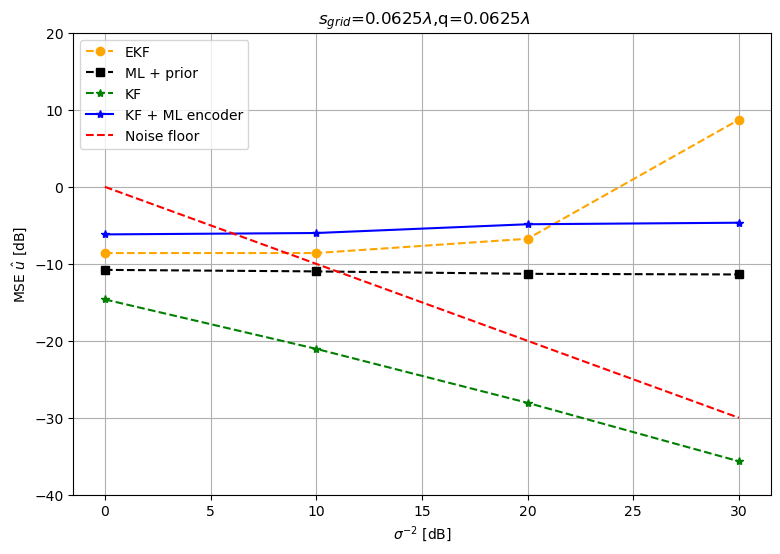

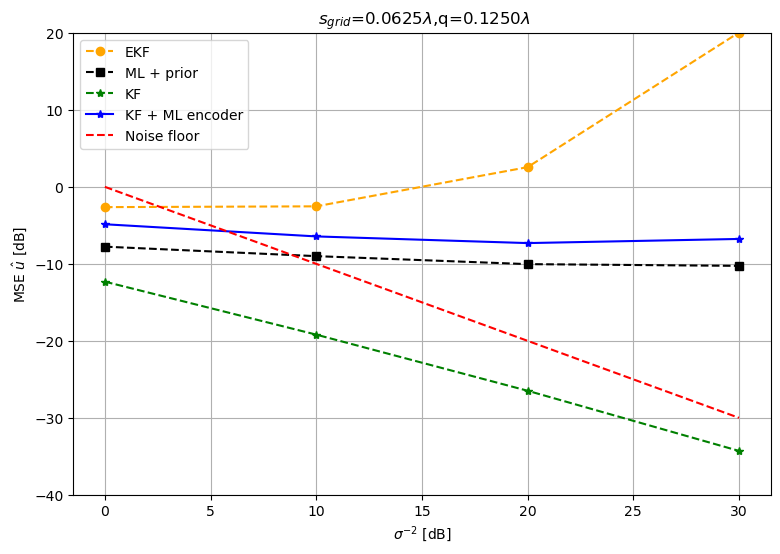

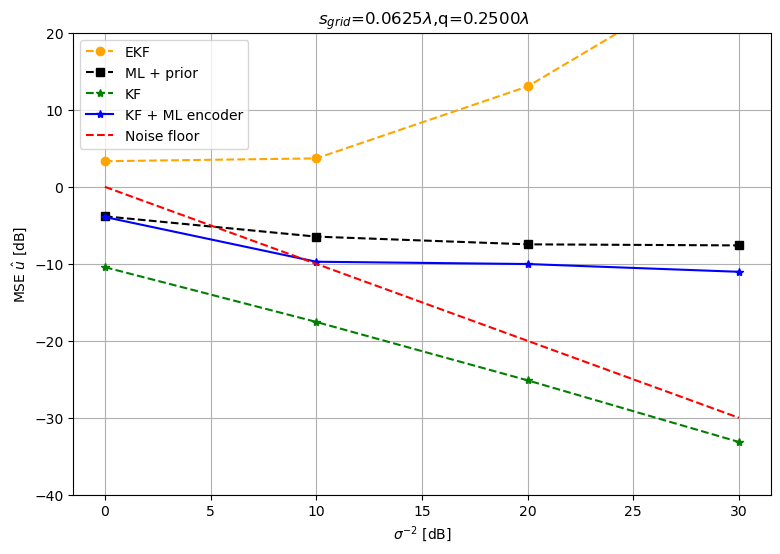

In [19]:
#---------------------------------------------------------------
#load and plot results
for q in q_list:
    for searchfactor in searchfactor_list:
        for ml_resol in ml_resol_list:
            
            path=filepath+f"/trajectory_{Length_used}"
            #load the results
            data = np.loadtxt(path+f'/Tra_Exp1_MSE_{searchfactor}_q_{q/lmb:.4f}lmb'+f'_grid_{ml_resol/lmb:.3f}lmb.txt')
            noise_dB=data[0:4]
            KF_ML_MSE_mean_dB=data[4:8]
            ML_MSE_xy_mean_dB=data[8:12]
            EKF_xy_mean_dB=data[12:16]
            KF_xy_mean_dB=data[16:20]

            #plot the results
            plot_result_EXP1((9,6),noise_dB,KF_ML_MSE_mean_dB,ML_MSE_xy_mean_dB,EKF_xy_mean_dB,KF_xy_mean_dB)
            plt.title(r" $s_{grid}$="+f"{ml_resol/lmb:.4f}"+r"$\lambda$"+f",q={q/lmb:.4f}"+r"$\lambda$")
    
            plt.savefig(path +f'/Tra_{Length_used}_Exp1_MSE_{searchfactor}_q_{q/lmb:.4f}lmb'+f'_grid_{ml_resol/lmb:.3f}lmb'+'.png')
            plt.savefig(path +f'/Tra_{Length_used}_Exp1_MSE_{searchfactor}_q_{q/lmb:.4f}lmb'+f'_grid_{ml_resol/lmb:.3f}lmb'+'.eps',format='eps') 

            # plt.savefig(filepath +f'/Tra_Exp1_MSE_{searchfactor}q_{q:.3f}'+f'_grid_{ml_resol/lmb:.3f}lmb'+'.png')
            # plt.savefig(filepath +f'/Tra_Exp1_MSE_{searchfactor}q_{q:.3f}'+f'_grid_{ml_resol/lmb:.3f}lmb'+'.eps',format='eps') 
            